# **Project 5: Expectation Maximization**
## Amaan Rahman  & Daniel Mezhiborsky
### ECE 474 
### Professor Keene

# **Abstract**

This project implements the expectation-maximization (EM) algorithm. The purpose of this algorithm is to find the maximum likelihood solutions for models with latent variables. The procedure of EM follows: 

### **Initialization**
$\mathbf{\mu}_k$: mean vector of gaussian associated to cluster *K*

$\mathbf{\Sigma}_k$: covariance matrix of gaussian assocated to cluster *K*

$\pi_k$: mixing coefficients associated to cluster *K*

Initialize $\mathbf{\mu}_k,~\mathbf{\Sigma}_k,~\pi_k$
### **E Step**
$\gamma(z_{nk})$: responsibility that component $k$ takes to explain observation $\mathbf{x}_n$

$$
\gamma(z_{nk}) = \frac{\pi_k\mathcal{N}\left(\mathbf{x}_n | \mathbf{\mu}_k,\mathbf{\Sigma}_k\right)}{\sum_{j=1}^K\pi_j\mathcal{N}\left(\mathbf{x}_n | \mathbf{\mu}_j,\mathbf{\Sigma}_j\right)}
$$
### **M Step**
$$
N_k = \sum_{n=1}^N\gamma(z_{nk})
$$

$$
\mathbf{\mu}_k^{new} = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})\mathbf{x}_n
$$

$$
\mathbf{\Sigma}_k^{new} = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})\left(\mathbf{x}_n - \mathbf{\mu}_k^{new}\right)\left(\mathbf{x}_n - \mathbf{\mu}_k^{new}\right)^{\text{T}}
$$
### **Evaluation of Log-Likelihood**
$$
\text{ln}~p\left(\mathbf{X}|\mathbf{\mu},\mathbf{\Sigma},\mathbf{\pi}\right)=\sum_{n=1}^N\text{ln}\left\{\sum_{k=1}^K\pi_k\mathcal{N}\left(\mathbf{x}_n|\mathbf{\mu}_k,\mathbf{\Sigma}_k\right)\right\}
$$

We utilized the EM algorithm to develop a Gaussian Mixture Model (GMM) on 1D data of 3-class clusters randomly selected from gaussian distributions. The goal is to estimate the true parameters of the gaussian distributions utilized to generate the clusters of 1D data. In this experiment, we develop an animation to show the evolution how univariate gaussian pdfs' hyperparameters are maximized to estimate the true parameters of the distrubution that the sample data was drawn from. We observe fail cases, where the GMM cannot distinguish overlapping data points selected from similar gaussian distributions. 

We also applied the same EM algorithm with the Old Faithful dataset. Unlike the GMM experiment, the data is 2D or, in other words, the feature space is 2-dimensional. Furthermore, the number of class is 2. In this experiment, we show how we can use the EM algorithm to classify clusters of data by maximizing the hyperparameters of a multivariate normal distribution. We also, utilize the responsibilities as a tool to inidicate the evolution of how the data is classified as 2 distinct classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import HTML
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from tqdm import trange, tqdm

%matplotlib inline
rc('animation', html='html5')
sns.set()

In [ ]:
def DataGen(K : int, N : int, seed: int):
    '''
    Generate data space for EM experiments

    Parameters
    ----------
    K = number of clusters
    N = number of samples
    seed = seed for reproducibility of results
    '''
    rng = np.random.default_rng(seed)
    MU = rng.choice(np.linspace(-5, 5), size=K)
    SIG = rng.choice(np.linspace(0.3, 1), size=K)
    
    X = [
        rng.normal(
            loc=m,
            scale=s,
            size=(N, 1)
        )
        for m, s in zip(MU, SIG)
    ] 

    X = np.concatenate(X, axis=1)
    np.random.shuffle(X)

    return pd.DataFrame(data=X, columns=[f'K{k}' for k in range(K)])


In [ ]:
class ExpectationMaximization(object):

    gauss = {
         '1': [norm, ('loc', 'scale')],
         '2': [multivariate_normal, ('mean', 'cov')]
    }

    def __init__(self, D, K, PI_0, MU_0, C_0):
        self.distr = self.gauss[str(D)] # get distribution based on feature dim
        self.K = K                      # number of classes
        self.pi = PI_0                  # init pi
        self.mu = MU_0                  # init mu
        self.cov = C_0                  # init covariance
        self.log_l = []                 # store log-likelihood scores
    

    def _fit(self, X, anim_flag = False, num_itr = 0):
        '''
        Return pdf at current state or after a set number of states

        Parameters
        ----------
        X = sample data space
        anim_flag = boolean for animatioon purposes
        num_itr = # of iterations to perform EM

        Return
        ------
        Plot space of K classes, and K pdfs
        '''
        x_min, x_max = np.min(X), np.max(X)
        x_plot = np.linspace(x_min, x_max, 100)
        
        if not anim_flag and num_itr != 0: 
            for _ in trange(num_itr):
                self._Expectation(X)
                self._Maximization()

        if 'cov' in self.distr[1]:  # check if distr is multivariate
            pdfs = []
            for mu, cov in zip(self.mu, self.cov):
                x_stack = np.dstack((x_plot, x_plot))
                kwargs = dict(zip(self.distr[1], [mu, cov]))
                pdf = self.distr[0].pdf(x = x_stack, **kwargs)
                pdfs.append(pdf)
        else:                       # else distr is univariate 
            kwargs = dict(zip(self.distr[1], [self.mu, self.cov]))
            pdfs = self.distr[0].pdf(x = x_plot, **kwargs)

        return (
            np.tile(x_plot, (self.K, 1)).T, 
            np.array(pdfs).T
        )


    def _plot_ll(self):
        '''
        Generate plot of log-likelihood convergence
        '''
        x = np.arange(0, len(self.log_l))
        plt.plot(x, self.log_l)
        plt.title("Log-Likelihood Convergence Plot")
        plt.xlabel("# of iterations")


    def _Expectation(self, X : np.ndarray):
        '''
        Evaluate log-likelihood on the current parameters and perform
        the Expectation step

        Parameters
        ----------
        X = dataset of observations

        Description
        -----------
        M = # of attributes (in this case there are 3: pi, mu, cov)
        attr: ragged (K, M)-array that stores all attributes

        Apply the responsibily function to each column (axis = 1) of the 'attr' array to 
        generate a gamma; a column contains an index from each attribute

        dim(gamma) = (K, N)
        '''
        self.X = X
        a = (self.pi, self.mu, self.cov)                # singleton attribute container
        attr = np.array(tuple(zip(*a)), dtype=object)   # collection of attribute containers
        self.gamma = np.squeeze(np.apply_along_axis(
            arr = attr, 
            func1d = self.__responsibility,
            axis = 1
        ))

        ll = np.sum(np.log(np.sum(self.gamma, axis=1)))  # log-likelihood
        self.log_l.append(ll)

        # ---------- E-Step ---------- #
        self.gamma /= np.sum(self.gamma, axis=0)


    def _Maximization(self):
        '''
        Perform Maximization step and update mu, cov, and pi
        '''
        x_dims = self.X.shape

        # get # of samples and features, respectively
        N, D = (x_dims, 1) if len(x_dims) < 2 else x_dims

        # N_k values (effective number of pointer for component k)
        NK = np.sum(self.gamma, axis=1)
        NK = NK if D == 1 else NK.reshape(self.K, 1)

        # update mean
        # (K, D) =squeeze= [(1, K, N) @ (N, D)] / (K, 1)
        self.mu = np.squeeze((self.gamma[None, ...] @ self.X)) / NK 

        # update covariance
        dist = self.X[None, ...] - self.mu[:, None] # (1, N, D) - (K, 1, D) = (K, N, D)
        dist = dist[..., None] if D == 1 else dist
        
        # (K, D, D) =squeeze= {[(K, N, D) * (K, N, 1)].T(0, 2, 1) @ (K, N, D)} / NK
        self.cov = np.squeeze(((dist * self.gamma[..., None]).transpose(0, 2, 1) @ dist)) / NK
        if 'scale' in self.distr[1]:    # check if distr is univariate norm
            self.cov = np.sqrt(self.cov)[..., None]
            self.mu = self.mu[..., None]

        # update pi 
        self.pi = NK / N


    def __responsibility(self, attr):
        '''
        Find the responsibility of component 'attr' takes on X

        Parameters
        ----------
        attr = kth component of attributes
        '''
        pi, m, c = attr

        kwargs = dict(zip(self.distr[1], [m, c]))
        return pi * self.distr[0].pdf(x = self.X, **kwargs)


# **1-D Gaussian Mixture EM**

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.close()
def fit_animate(frame, X, pbar_init = False):
    '''
    Base animation function that will execute per frame.
    Plots histogram of sample data space, and the predicted gaussian
    pdfs that "classify" gaussian clusters. 

    Parameters
    ----------
    frame: frame # to execute function
    X: sample data space
    '''
    ax.clear()
    sns.histplot(data = df, bins = 50, kde=False, stat='density', ax=ax)
    x_plot, pdfs = EM1D._fit(X, anim_flag=True)
    ax.plot(x_plot, pdfs)
    EM1D._Expectation(X)
    EM1D._Maximization()
    ax.autoscale(tight=True)
    pbar.update(1) 
    if frame == NUM_ITERATIONS - 1: 
        pbar.close() 


## Expectation-Maximization in Action

### CONSIDERATIONS

The colors of the gaussian pdfs are independant of the colors of the histogram 
plots. For example, if an orange gaussian tracks a histogram plot colored green,
there is no assumption to be made by the different colors. Thus, all colors are
independent of anything happening, although sometimes the colors do end up
being matched, it still means nothing and at the end of the day the EM algorithm is
working as expected even at fail cases. 

### SEED CASES

123: moderately difficult case, but definite convergence for ~250 iterations
1024: easy convergence case 
2048: fail case when means of 2 clusters are the same, and predicted pdfs 
      cannot track overlapping clusters with same means

*** WARNING ***
Iterations ~200 => ~2min - ~3min animation generation

In [ ]:
K = 3
SEED = 123 
NUM_ITERATIONS = 250
NUM_SAMPLES = 1000
NUM_FEATURES = 1

# data prep
df = DataGen(K, NUM_SAMPLES, SEED)
X = df.to_numpy().flatten()
np.random.shuffle(X)

# init conditions
PI_0 = np.array([1 / K] * K).reshape(-1, 1)
MU_0 = np.array([-0.1, 0, 0.1])[..., None]
COV_0 = np.array(np.squeeze([np.eye(NUM_FEATURES)] * K))[..., None]

# init EM for 1D
EM1D = ExpectationMaximization(NUM_FEATURES, K, PI_0, MU_0, COV_0)

# animation of fit -> contains init plot, intermediate plots, and final plot
pbar = tqdm(total=NUM_ITERATIONS + 1)   # +1 overhead for FuncAnimation
FuncAnimation(
    fig=fig, 
    func=fit_animate, 
    fargs=(X, ), 
    frames=range(NUM_ITERATIONS), 
    interval=100, 
    repeat=False
)

100%|██████████| 251/251 [01:40<00:00,  2.50it/s]


## Log-Likelihood Convergence Plot

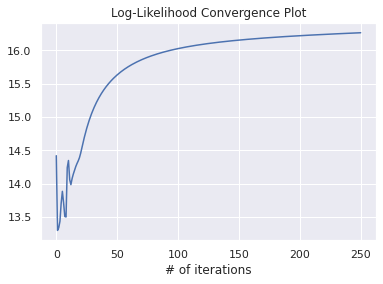

In [ ]:
# plot log-likelihood scores
EM1D._plot_ll()

# **2-D EM**


In [ ]:
from sklearn.preprocessing import StandardScaler
# get old faithful dataset
of_df = pd.read_csv("https://raw.githubusercontent.com/gchoi/Dataset/master/OldFaithful.csv")

# standardize data
of_df = pd.DataFrame(StandardScaler().fit_transform(of_df))

# relabel data
labels = {
    'x': 'Duration of Eruption (min)',
    'y': 'Time Till Next Eruption (min)'
}
of_df.rename(columns = {
    0: labels['x'],
    1: labels['y']
}, inplace=True)


In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, attr, ax, facecolor='none', **kwargs):
    """
    REFERENCE: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    attr : container for mean and covariance

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    mu, cov = attr
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0])
    scale_y = np.sqrt(cov[1, 1])

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0], mu[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

100%|██████████| 20/20 [00:00<00:00, 1454.23it/s]


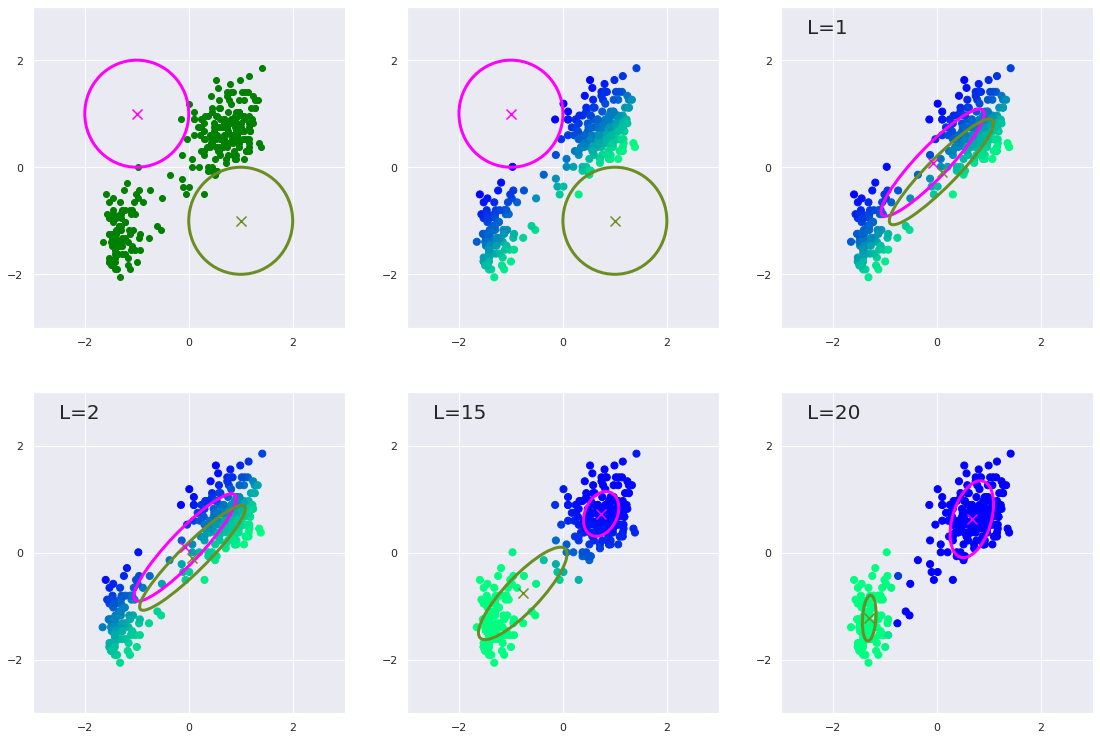

In [ ]:
K = 2

# data prep
data = of_df.to_numpy()
NUM_SAMPLES, NUM_FEATURES = data.shape
data = data.flatten().reshape(-1, NUM_FEATURES)
NUM_ITERATIONS = [2, 15, 20]

# initial conditions
PI_0 = np.array([1 / K] * K).reshape(-1, 1)
MU_0 = np.array([[-1, 1], [1, -1]])
COV_0 = np.array([np.eye(2), np.eye(2)])
EM2D = ExpectationMaximization(NUM_FEATURES, K, PI_0, MU_0, COV_0)

# figure setup
fig = plt.figure(figsize=(19, 13))
colors = ['magenta', 'olivedrab']
plt_shape = [2, 3, 1]

def of_plot(data, L=0, show_responsibility = False):
    '''
    Plot the data and confidence ellipses (1 std contour of multivariate)
    '''
    x, y = data.T

    ax = fig.add_subplot(*plt_shape)
    ax.set_xlim([-3, 3])
    ax.set_xticks([-2, 0, 2])
    ax.set_ylim([-3, 3])
    ax.set_yticks([-2, 0, 2])
    for i in range(NUM_FEATURES):
        attr = (EM2D.mu[i], EM2D.cov[i])

        # fit with current hyperparameters
        _, conf_space = EM2D._fit(data, num_itr=0)

        # generate confidence ellipse
        confidence_ellipse(conf_space[0], conf_space[1], attr, ax, edgecolor=colors[i], lw=3)

        # plot mean of confidence ellipse
        ax.scatter(EM2D.mu[i][0], EM2D.mu[i][1], c=colors[i], s=100, marker='x', zorder=10)
    
    if not show_responsibility:
        # init dataset plot
        ax.scatter(x, y, color='green')
    else:
        # dataset classification colorized
        ax.scatter(x, y, c=EM2D.gamma[1], cmap='winter', s=50, zorder=1)
        if L != 0: ax.annotate(f"L={L}", xy=(-2.5, 2.5), fontsize=20)

    plt_shape[2] += 1


def of_fit_init(data):
    '''
    Plot throughout 1 EM step
    '''
    # plot 9.8a
    of_plot(data)
    
    # plot 9.8b
    EM2D._Expectation(data)
    of_plot(data, show_responsibility=True)

    # plot 9.8c
    EM2D._Maximization()
    of_plot(data, L=1, show_responsibility=True)


def of_fit(data):
    '''
    Plot after different iterations of EM steps
    '''
    # plots 9.8d - 9.8f
    for itr in NUM_ITERATIONS:
        _, pdfs = EM2D._fit(data, num_itr=itr)
        of_plot(data, L=itr, show_responsibility=True)


of_fit_init(data)
of_fit(data)